<a href="https://colab.research.google.com/github/Mohammad-Amirifard/Traffic-forecasting/blob/main/Notebooks/EDA_traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
from tqdm import tqdm
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from matplotlib import style
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline
warnings.filterwarnings('ignore')

# **Load Dataset**

In [2]:
!gdown 113Jq2I2ZHWj0CwxdLxt3yBID_53RroCR # Load dataset
!unzip -qq "/content/IntraTM.zip" -d "/content/files" # unzip to a folder called files

Downloading...
From: https://drive.google.com/uc?id=113Jq2I2ZHWj0CwxdLxt3yBID_53RroCR
To: /content/IntraTM.zip
100% 10.8M/10.8M [00:00<00:00, 24.9MB/s]


# **EDA**

## a)Create a text file

We used linux command "ls" to collect all files names in a txt file to use later, then read that file and store it in a list


In [3]:
!ls "/content/files" >> "/content/file_names.txt" # Create a text file and store all files' names inside

with open('/content/file_names.txt','r') as file: # read this file
    file_names_list =file.read().splitlines()


print("first name is : ",file_names_list[0])
print("second name is: ",file_names_list[1])
print("...")
print("...")
print("...")
print("last name is :",file_names_list[-1])

first name is :  IntraTM-2005-01-01-00-30.xml
second name is:  IntraTM-2005-01-01-00-45.xml
...
...
...
last name is : IntraTM-2005-01-31-23-45.xml


## b)extract useful information from html files and create a dataframe

We used parsing to look at html files and extract each traffic for each path denoted by src_id and dst_id. Next, we store them in different dataframes. After that we merged all dataframes together to have a bigger dataframe covering all traffics for all paths.

In [4]:
def create_list_of_dfs(files_names):

  """Input: names of files in the dataset folder as a list
     Output: a list of dataframes for all files"""


  dataframe_list =  list()

  for index,file_name in enumerate(tqdm(files_names,"Processing")): # Iterate over files

      df = pd.DataFrame({})
      file_path = '/content/files/'+ file_name

      tree = ET.parse(file_path) # parsing the file
      root = tree.getroot()
      date = file_name.split(".")[0].split("IntraTM-")[1] # extracting only date from file_name
      #eg : file_path="/content/files/IntraTM-2005-01-01-00-30.xml" ,
      #date = 2005-01-01-00-30


      # fixed variables to store values
      src_id_list  = list()
      dst_id_list = list()
      traffic_list =  list()


      for src in root.findall(".//src"):  # finding where we have src in html file
          src_id = src.get('id') #  receive src_id

          for dst in src.findall('dst'): # run a loop for that src to find all destinations
              dst_id = dst.get('id')  # receive dst id
              traffic = dst.text   # dst value

              src_id_list.append(int(src_id)) # store src_id
              dst_id_list.append(int(dst_id)) # store dst_id
              traffic_list.append(float(traffic)) # store traffic

      # add values to the dataframe
      df.insert(loc=0,column="src_id",value=src_id_list)
      df.insert(loc=1,column="dst_id",value=dst_id_list)
      df.insert(loc=2,column=f'{date}',value=traffic_list)

      # add dataframe to a list
      dataframe_list.append(df)

  return dataframe_list

In [5]:
dataframe_list = create_list_of_dfs(files_names=file_names_list)

number_of_files = len(dataframe_list)
print(f'\nFor each file, we created a separate dataframe like the following dataframes for example, meaning that now we have {number_of_files} dataframes as many as the number of files')
print('Number_of_files:',number_of_files)



# Let's see two dataframes
print('First dataframe')
display(dataframe_list[0])
print('Second dataframe')
display(dataframe_list[1])

Processing: 100%|██████████| 2941/2941 [00:14<00:00, 206.95it/s]


For each file, we created a separate dataframe like the following dataframes for example, meaning that now we have 2941 dataframes as many as the number of files
Number_of_files: 2941
First dataframe


,src_id,dst_id,2005-01-01-00-30
0,12,12,396708.2311
1,12,13,28093.7511
2,12,19,16916.5600
3,12,23,3662.8089
4,12,8,6552.9333
...,...,...,...
472,15,14,0.4622
473,15,11,496.4711
474,15,9,3781.9644
475,15,17,889.2267


Second dataframe


,src_id,dst_id,2005-01-01-00-45
0,12,12,338875.5644
1,12,13,28485.3422
2,12,19,11769.3422
3,12,23,1950.5067
4,12,8,5445.9111
...,...,...,...
470,15,14,3.1644
471,15,11,493.4844
472,15,9,888.7289
473,15,17,8000.8178


In [6]:
# It's time to merge all dataframes togheter using pd.merge and outer mode.

df = dataframe_list[0]                      # Initialize the merged DataFrame with the first DataFrame in the list
for dataframe in tqdm(dataframe_list[1:]):  # Iterate over the remaining DataFrames and perform an outer join
    df = pd.merge(df, dataframe, on=['src_id', 'dst_id'], how='outer')

df.to_csv('traffic.csv',index=False)             #Save as a csv file

100%|██████████| 2940/2940 [02:06<00:00, 23.26it/s]


## c)Load created dataframe to work on

In [7]:
traffic_dataframe = pd.read_csv("/content/traffic.csv")
display(traffic_dataframe)
print('*'*200)
print('As shown above, we can see that in our dataframe some self_loop are avaiable and some NaN values for others path')

,src_id,dst_id,2005-01-01-00-30,2005-01-01-00-45,2005-01-01-01-00,2005-01-01-01-15,2005-01-01-01-30,2005-01-01-01-45,2005-01-01-02-00,2005-01-01-02-15,...,2005-01-31-21-30,2005-01-31-21-45,2005-01-31-22-00,2005-01-31-22-15,2005-01-31-22-30,2005-01-31-22-45,2005-01-31-23-00,2005-01-31-23-15,2005-01-31-23-30,2005-01-31-23-45
0,12,12,396708.2311,338875.5644,341894.5422,347749.5822,320159.4933,336569.9733,304732.9422,318965.9822,...,311502.9422,317854.7644,315334.9156,320295.8133,318063.6711,320748.4711,298609.4489,297175.1556,305258.2222,310534.2756
1,12,13,28093.7511,28485.3422,38402.6756,31250.8356,50818.0000,20076.4000,33443.3600,40365.1111,...,30722.8444,31104.5422,47739.3156,35189.5644,33934.6667,30320.1689,25305.5378,26145.2978,28801.8756,30300.6667
2,12,19,16916.5600,11769.3422,5830.6311,7052.6489,6173.0222,4775.5111,5676.6489,4924.9511,...,3370.6400,1122.3911,1256.7911,2634.7289,3196.2667,4596.8444,7102.2844,5395.0400,4077.1556,10089.4489
3,12,23,3662.8089,1950.5067,2293.3778,1915.7244,1556.5333,1623.6089,1072.9422,855.4222,...,194.0889,726.8267,4217.2444,16669.8222,17209.4222,8732.4267,62.8800,412.2133,166.9067,119.0400
4,12,8,6552.9333,5445.9111,5831.0578,5757.1556,5453.6000,5178.4000,7083.3333,8414.4267,...,2915.8933,2589.1467,4792.2933,4280.5689,3852.2133,2539.4667,2017.9289,1540.2044,1812.3022,1205.4667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,10,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
518,20,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.8178,NaN,NaN,0.8178,NaN,1.6356,0.8178,NaN,0.8178
519,16,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
520,20,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


********************************************************************************************************************************************************************************************************
As shown above, we can see that in our dataframe some self_loop are avaiable and some NaN values for others path


In [8]:
column_names = traffic_dataframe.columns       # store column names
timestamps = column_names[2:]   # Store timestamps


## d) Change dtype float64 to flaot 32
We did this to decrease the computations during different process.

In [9]:
#change float 64 to 32 for traffic to decrease computation ahead
print("*"*100)
print('Original inforamtion of dataframe:')
print("*"*100)
traffic_dataframe.info()
print("*"*100)
print('Updated inforamtion of dataframe with lower memory:')
print("*"*100)
traffic_dataframe[timestamps] = traffic_dataframe[timestamps].astype(np.float32)
traffic_dataframe.info()

****************************************************************************************************
Original inforamtion of dataframe:
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Columns: 2943 entries, src_id to 2005-01-31-23-45
dtypes: float64(2941), int64(2)
memory usage: 11.7 MB
****************************************************************************************************
Updated inforamtion of dataframe with lower memory:
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Columns: 2943 entries, src_id to 2005-01-31-23-45
dtypes: float32(2941), int64(2)
memory usage: 5.9 MB


## e) Remove and or Fill rows with lots of NaN values

In [10]:
print('In the following, you can see the number of NaN values in each row:\n')
print('Row      No_NaN')
print('___      ______')
nan_counts = traffic_dataframe.isnull().sum(axis=1)
nan_counts


In the following, you can see the number of NaN values in each row:

Row      No_NaN
___      ______


0         0
1         0
2         0
3         1
4         0
       ... 
517    2935
518    2821
519    2939
520    2939
521    2939
Length: 522, dtype: int64

In [11]:
# We are trying to remove rows with nan values more than 25%
index_list_to_remove  = list()
nan_counts_index = nan_counts.index
nan_count_values = nan_counts.values
for nan_value_index,nan_value  in zip(nan_counts_index,nan_count_values):
  if (nan_value/number_of_files)*100 >25:
    index_list_to_remove.append(nan_value_index)

print("This indexes have more nan values, so we need to remove them")
print(index_list_to_remove)

print('*'*200)
print('Updated dataframe:\n')
traffic_dataframe.drop(index_list_to_remove,inplace=True)
traffic_dataframe.reset_index(inplace=True)
traffic_dataframe.drop(['index'],axis=1,inplace=True)
display(traffic_dataframe)

This indexes have more nan values, so we need to remove them
[13, 33, 54, 66, 75, 77, 83, 87, 96, 98, 127, 137, 159, 180, 202, 213, 216, 223, 244, 245, 264, 286, 298, 299, 300, 304, 309, 326, 336, 337, 352, 365, 366, 385, 407, 429, 451, 472, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521]
********************************************************************************************************************************************************************************************************
Updated dataframe:



,src_id,dst_id,2005-01-01-00-30,2005-01-01-00-45,2005-01-01-01-00,2005-01-01-01-15,2005-01-01-01-30,2005-01-01-01-45,2005-01-01-02-00,2005-01-01-02-15,...,2005-01-31-21-30,2005-01-31-21-45,2005-01-31-22-00,2005-01-31-22-15,2005-01-31-22-30,2005-01-31-22-45,2005-01-31-23-00,2005-01-31-23-15,2005-01-31-23-30,2005-01-31-23-45
0,12,12,396708.218750,338875.562500,341894.531250,347749.593750,320159.500000,336569.968750,304732.937500,318965.968750,...,311502.937500,317854.750000,315334.906250,320295.812500,318063.656250,320748.468750,298609.437500,297175.156250,305258.218750,310534.281250
1,12,13,28093.751953,28485.341797,38402.675781,31250.835938,50818.000000,20076.400391,33443.359375,40365.109375,...,30722.843750,31104.542969,47739.316406,35189.562500,33934.667969,30320.167969,25305.537109,26145.296875,28801.875000,30300.666016
2,12,19,16916.560547,11769.341797,5830.630859,7052.648926,6173.021973,4775.511230,5676.648926,4924.951172,...,3370.639893,1122.391113,1256.791138,2634.729004,3196.266602,4596.844238,7102.284180,5395.040039,4077.155518,10089.449219
3,12,23,3662.808838,1950.506714,2293.377686,1915.724365,1556.533325,1623.608887,1072.942261,855.422180,...,194.088898,726.826721,4217.244629,16669.822266,17209.421875,8732.426758,62.880001,412.213287,166.906693,119.040001
4,12,8,6552.933105,5445.911133,5831.057617,5757.155762,5453.600098,5178.399902,7083.333496,8414.426758,...,2915.893311,2589.146729,4792.293457,4280.568848,3852.213379,2539.466797,2017.928955,1540.204346,1812.302246,1205.466675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,15,2,1326.924438,572.444397,533.786682,556.604370,575.795593,628.737793,446.000000,586.044373,...,208.284393,111.973297,119.324402,182.293304,111.555603,198.826706,123.555603,43.866699,51.306702,935.715576
435,15,11,496.471100,493.484406,292.071106,182.488907,267.822205,51.137798,103.173302,135.279999,...,19.004400,0.880000,8.266700,1.564400,16.835600,14.720000,0.435600,0.462200,13.600000,13.866700
436,15,9,3781.964355,888.728882,1063.511108,1211.875610,1142.719971,1020.337830,844.088928,1155.155640,...,1019.119995,2097.875488,2995.155518,5178.213379,3393.697754,508.044403,977.688904,1867.662231,296.853302,299.715607
437,15,17,889.226685,8000.817871,3387.182129,544.746704,453.786713,941.253296,4769.849121,5940.586914,...,171.235596,355.911102,450.577789,760.711121,8573.040039,695.128906,689.431091,2366.382080,381.626709,228.142197


In [12]:
print('But we have still several Nan Values for the rows with less than 25% NaN Values:\n')
print('Row      No_NaN')
print('___      ______')
traffic_dataframe.isnull().sum(axis=1)

But we have still several Nan Values for the rows with less than 25% NaN Values:

Row      No_NaN
___      ______


0       0
1       0
2       0
3       1
4       0
       ..
434     0
435    25
436     0
437     0
438     0
Length: 439, dtype: int64

In [13]:
traffic_dataframe.fillna(axis='index',method="ffill",inplace= True) # Fill these NaN values with forward fill method avaiable in fillna function

# Chech NaN values again to make sure our dataframe does not have any NaN values
number_of_nans = traffic_dataframe.isnull().sum(axis=1).values
sum =0
for item in number_of_nans:
  if item >0:
    sum +=1

if sum >0:
  print('Oppps. This dataframe has NaN values yet.')
else:
  print("Great. This dataframe does not have any NaN values")

Great. This dataframe does not have any NaN values


## f) Plot graph

In [14]:
def plot_graph(dataframe,row,decompose=False,additioanl_title = ''):



  # Show the plot
  if decompose == True:

      data = dataframe.iloc[row,2:]
      src_id = df.loc[row][0]
      dst_id = df.loc[row][1]

      mul_decomposition = sm.tsa.seasonal_decompose(data, model = 'multiplicative',period=96)
      trend = mul_decomposition.trend
      seasonal = mul_decomposition.seasonal
      residual = mul_decomposition.resid

      fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 10))
      positions = range(0, len(data), 100) # Define the positions for x-ticks (e.g., every 50th point)
      labels = [timestamps[i] for i in positions]       # Define the corresponding labels for these positions


      # Plot original
      axes[0].plot(data, label=f'Traffic_{row} with src_id:{int(src_id)},and dst_id:{int(dst_id)}', color='blue')
      axes[0].grid(True, color='brown', linestyle='--', alpha=0.5)
      axes[0].set_xticks([])

      axes[0].legend()

      # Plot trend
      axes[1].plot(trend, label='Trend', color='blue')
      axes[1].grid(True, color='brown', linestyle='--', alpha=0.5)
      axes[1].set_xticks([])
      axes[1].legend()

      # Plot seasonal
      axes[2].plot(seasonal, label='Seasonal', color='blue')
      axes[2].grid(True, color='brown', linestyle='--', alpha=0.5)
      axes[2].set_xticks([])

      axes[2].legend()

      # Plot residual
      axes[3].plot(residual, label='Residual', color='blue')
      axes[3].grid(True, color='brown', linestyle='--', alpha=0.5)
      axes[3].set_xticks(positions)
      axes[3].set_xticklabels(labels, rotation=90)
      axes[3].legend()

      plt.tight_layout()
      plt.show()
      return mul_decomposition.trend,mul_decomposition.seasonal,mul_decomposition.resid


  else:
      fig, ax = plt.subplots(figsize=(12, 4))
      plt.style.use('ggplot')

      data = dataframe.iloc[row,2:]
      src_id = df.loc[row][0]
      dst_id = df.loc[row][1]

      data.plot(label=f'{additioanl_title} Traffic_{row} with src_id:{int(src_id)},and dst_id:{int(dst_id)}',color='blue')
      plt.grid(True, color='brown', linestyle='--', alpha=0.5)


      # Define the positions for x-ticks (e.g., every 50th point)
      positions = range(0, len(data), 100)
      # Define the corresponding labels for these positions

      labels = [timestamps[i] for i in positions]

      # Set the positions and labels of the x-ticks
      ax.set_xticks(positions)
      ax.set_xticklabels(labels, rotation=90)  # Rotation to vertical
      plt.legend()
      plt.show()

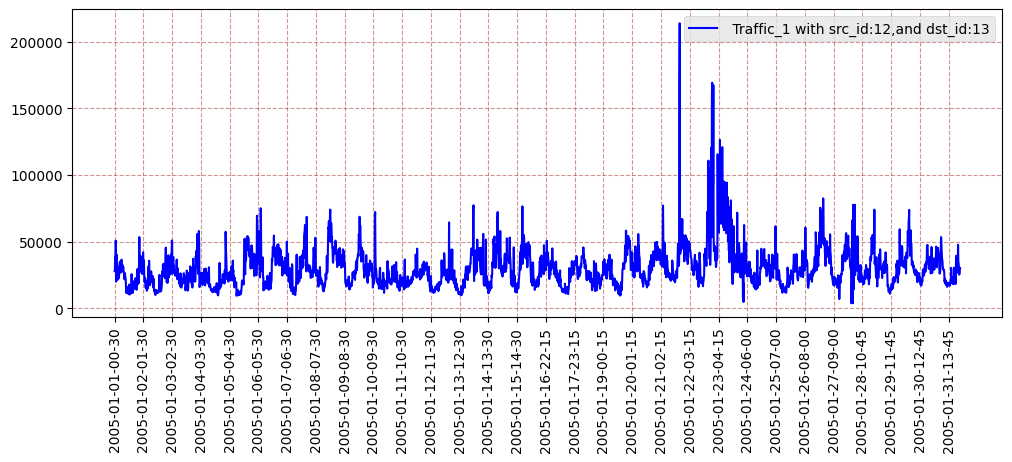

In [15]:
plot_graph(traffic_dataframe,1)


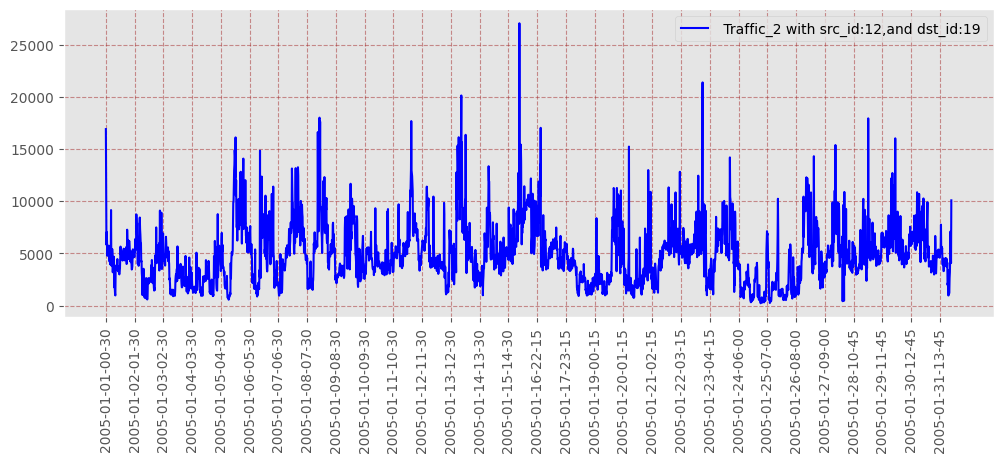

In [16]:
plot_graph(traffic_dataframe,2)

# **Stationarity**
Stationarity is one of the most important properties of time series.But what does it mean for data to be stationary?

If a time series is **stationary**, that means it does not change its statistical properties over time, namely its mean and variance. (The constancy of variance is called homoscedasticity). Also, it should not contain seasonality.

We can then summarize the 3 main characteristics as follows:


**1_Constant mean**


**2_Constant variance**


**3_No seasonality**






## a) Check stationary by statistical tests like **ADF** and **KPSS**

In [17]:
def check_stationary_print(dataframe,row=2,non_stationary=False):

  """ Input: dataframe and row which shows each traffic
      Output: _ (Just show result from two mentioned tests.)
  """
  if non_stationary == False:
    X = dataframe.iloc[row,2:] # Get data of the sepecified row. 2 here means we don't want src_id and dst_id
  else:
    X =dataframe.iloc[row]
  threshold = 0.1 # This the threshold for checking p_value

  #ADF TEST#
  ##############################################################################
  print('*'*100)
  adfuller_result = adfuller(X)
  print('ADF Statistic: %f' % adfuller_result[0])
  if adfuller_result[1] <= threshold:

    print('p-value: %f' % adfuller_result[1],'\t\t\t ***ADF says this time series is Stationary***')

  else:
    print('p-value: %f' % adfuller_result[1],'\t\t\t ***ADF says this time series is Non-Stationary***')

  print('Critical Values:')
  for key, value in adfuller_result[4].items():
      print('\t%s: %.3f' % (key, value))


  #KPSS TEST#
  ##############################################################################
  print('*'*100)
  kpss_result = kpss(X)
  print('KPSS Statistic: %f' % kpss_result[0])
  if kpss_result[1] <= threshold:

    print('p-value: %f' % kpss_result[1],'\t\t\t ***KPSS says this time series is Stationary***')

  else:
    print('p-value: %f' % kpss_result[1],'\t\t\t ***KPSS says this time series is Non-Stationary***')

  print('Critical Values:')
  for key, value in kpss_result[3].items():
      print('\t%s: %.3f' % (key, value))

In [18]:
check_stationary_print(dataframe=traffic_dataframe,row=2)

****************************************************************************************************
ADF Statistic: -7.699552
p-value: 0.000000 			 ***ADF says this time series is Stationary***
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
****************************************************************************************************
KPSS Statistic: 0.177601
p-value: 0.100000 			 ***KPSS says this time series is Stationary***
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


In [19]:
def check_stationary_for_all_data(dataframe):
  """ Input: dataframe includin all traffic
      Output: Stationary_dataframe which shows weather the timeseries is stationary or not
  """

  threshold = 0.1 # This the threshold for checking p_value
  number_of_rows =  dataframe.shape[0]
  stationary_list = list()
  adfuller_result_list = list()
  kpss_result_list = list()

  for row in tqdm(range(number_of_rows),"Please wait."):

    X = dataframe.iloc[row,2:]
    adfuller_result = adfuller(X)
    kpss_result = kpss(X)
    if adfuller_result[1] <= threshold:
       adfuller_result_list.append(1)  # 1 means Stationary and 0 mean Non-Stationary
    else:
      adfuller_result_list.append(0)

    if kpss_result[1] <= threshold:
       kpss_result_list.append(1)
    else:
      kpss_result_list.append(0)


    if adfuller_result[1] <= threshold and kpss_result[1] <= threshold:
      stationary_list.append(1)
    else:
      stationary_list.append(0)

  stationary_dataframe = pd.DataFrame()
  stationary_dataframe.insert(loc=0,column="src_id",value=dataframe['src_id'])
  stationary_dataframe.insert(loc=1,column="dst_id",value=dataframe['dst_id'])
  stationary_dataframe.insert(loc=2,column="ADF",value=adfuller_result_list)
  stationary_dataframe.insert(loc=3,column="KPSS",value=kpss_result_list)
  stationary_dataframe.insert(loc=4,column='Stationary_status',value=stationary_list)

  return stationary_dataframe


In [20]:
stationary_df = check_stationary_for_all_data(dataframe = traffic_dataframe)

Please wait.: 100%|██████████| 439/439 [01:12<00:00,  6.04it/s]


In [21]:
print("Check Stationary by this dataframe.")
print("1--> Yes , 0-->No")
number_of_both_states = np.unique(stationary_df['Stationary_status'],return_counts=True)
print("Based on this dataframe, there are:")
print(f"{number_of_both_states[1][1]} Stationary timeseris and {number_of_both_states[1][0]} Non-Stationary timeseris")
stationary_df

Check Stationary by this dataframe.
1--> Yes , 0-->No
Based on this dataframe, there are:
430 Stationary timeseris and 9 Non-Stationary timeseris


,src_id,dst_id,ADF,KPSS,Stationary_status
0,12,12,1,1,1
1,12,13,1,1,1
2,12,19,1,1,1
3,12,23,1,1,1
4,12,8,1,1,1
...,...,...,...,...,...
434,15,2,1,1,1
435,15,11,1,1,1
436,15,9,1,1,1
437,15,17,1,1,1


In [22]:
non_stationary_traffic_indexes = stationary_df[stationary_df['Stationary_status']==0].index
print('The following indexes are for non_stationary traffics')
non_stationary_traffic_indexes

The following indexes are for non_stationary traffics


Index([45, 52, 147, 242, 253, 273, 320, 339, 360], dtype='int64')

## b) Make Non-Stationary timeseries Stationary

Make one of non_stationary traffic, Stationary


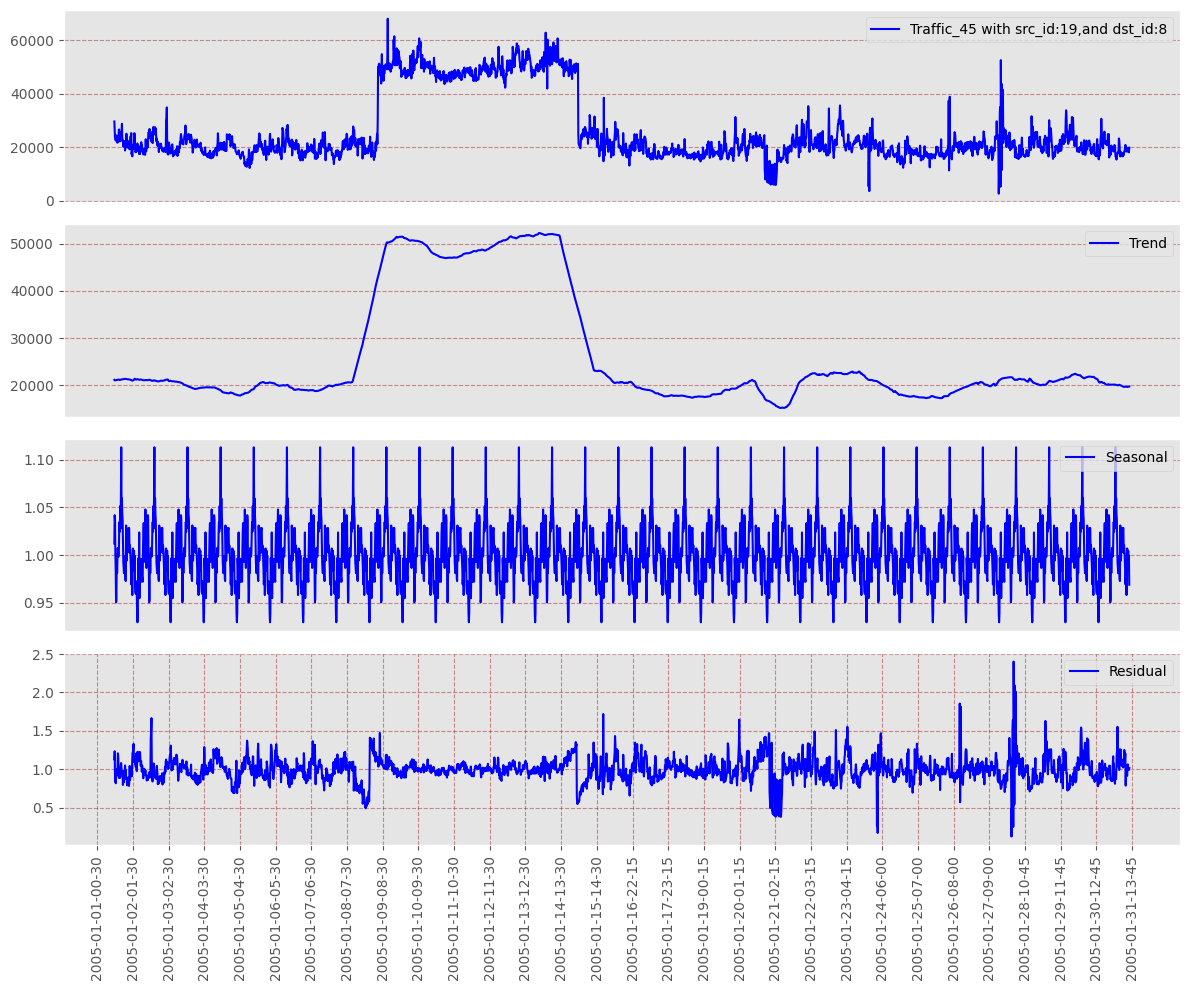

****************************************************************************************************
ADF Statistic: -10.796916
p-value: 0.000000 			 ***ADF says this time series is Stationary***
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
****************************************************************************************************
KPSS Statistic: 0.016197
p-value: 0.100000 			 ***KPSS says this time series is Stationary***
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
********************************************************************************************************************************************************************************************************
Great. This traffic now is Stationary
********************************************************************************************************************************************************************************************************


In [23]:
print('Make one of non_stationary traffic, Stationary')
index = 45
mul_decomposition_trend,mul_decomposition_seasonal,mul_decomposition_resid = plot_graph(traffic_dataframe,index,decompose=True)

# Check statistical tests for this traffic

threshold = 0.1
X = mul_decomposition_resid.dropna()
print('*'*100)
adfuller_result = adfuller(X)
print('ADF Statistic: %f' % adfuller_result[0])
if adfuller_result[1] <= threshold:

  print('p-value: %f' % adfuller_result[1],'\t\t\t ***ADF says this time series is Stationary***')

else:
  print('p-value: %f' % adfuller_result[1],'\t\t\t ***ADF says this time series is Non-Stationary***')

print('Critical Values:')
for key, value in adfuller_result[4].items():
    print('\t%s: %.3f' % (key, value))


#KPSS TEST#
##############################################################################
print('*'*100)
kpss_result = kpss(X)
print('KPSS Statistic: %f' % kpss_result[0])
if kpss_result[1] <= threshold:

  print('p-value: %f' % kpss_result[1],'\t\t\t ***KPSS says this time series is Stationary***')

else:
  print('p-value: %f' % kpss_result[1],'\t\t\t ***KPSS says this time series is Non-Stationary***')

print('Critical Values:')
for key, value in kpss_result[3].items():
    print('\t%s: %.3f' % (key, value))


print('*'*200)
print('Great. This traffic now is Stationary')
print('*'*200)

In [26]:
# do the same for all dataframe to make them stationary
for row in tqdm(range(traffic_dataframe.shape[0]), "Processing "):

  data = traffic_dataframe.iloc[row,2:]

  mul_decomposition = sm.tsa.seasonal_decompose(data, model = 'multiplicative',period=96)
  trend = mul_decomposition.trend.dropna()
  seasonal = mul_decomposition.seasonal.dropna()
  residual = mul_decomposition.resid.dropna()
  names =  residual.index

  if row == 0:
    seasonal_dataframe = pd.DataFrame(columns =residual.index )
    trend_dataframe = pd.DataFrame(columns =residual.index )
    residual_dataframe = pd.DataFrame(columns =residual.index )

    trend_dataframe.loc[len(trend_dataframe)] = trend
    seasonal_dataframe.loc[len(seasonal_dataframe)] = seasonal
    residual_dataframe.loc[len(residual_dataframe)] = residual

  else:

    trend_dataframe.loc[len(trend_dataframe)] = trend
    seasonal_dataframe.loc[len(seasonal_dataframe)] = seasonal
    residual_dataframe.loc[len(residual_dataframe)] = residual

#src_id and dst_id to dataframes
trend_dataframe.insert(loc=0,column='src_id',value=traffic_dataframe['src_id'])
trend_dataframe.insert(loc=1,column='dst_id',value=traffic_dataframe['dst_id'])

seasonal_dataframe.insert(loc=0,column='src_id',value=traffic_dataframe['src_id'])
seasonal_dataframe.insert(loc=1,column='dst_id',value=traffic_dataframe['dst_id'])

residual_dataframe.insert(loc=0,column='src_id',value=traffic_dataframe['src_id'])
residual_dataframe.insert(loc=1,column='dst_id',value=traffic_dataframe['dst_id'])

Processing : 100%|██████████| 439/439 [00:12<00:00, 34.88it/s]


In [27]:
residual_dataframe

,src_id,dst_id,2005-01-01-12-30,2005-01-01-12-45,2005-01-01-13-00,2005-01-01-13-15,2005-01-01-13-30,2005-01-01-13-45,2005-01-01-14-00,2005-01-01-14-15,...,2005-01-31-09-30,2005-01-31-09-45,2005-01-31-10-00,2005-01-31-10-15,2005-01-31-10-30,2005-01-31-10-45,2005-01-31-11-00,2005-01-31-11-15,2005-01-31-11-30,2005-01-31-11-45
0,12,12,0.780679,0.800145,0.774420,0.763970,0.763807,0.794805,0.827960,0.761704,...,0.956599,0.934247,0.938572,0.929098,0.932633,0.924473,0.915174,0.900986,0.897917,0.913994
1,12,13,0.488830,0.625709,0.586762,0.801563,0.500294,0.594228,0.759551,0.630608,...,0.895035,0.939140,0.864007,0.691082,0.786309,0.829648,0.731216,0.824740,0.644576,0.700634
2,12,19,0.799225,0.889419,1.099272,1.173455,1.049650,1.113329,1.102418,1.110032,...,0.994662,1.486023,1.255823,0.687004,0.764110,1.088094,1.192897,1.165830,1.161775,1.139114
3,12,23,0.073041,0.122230,0.042927,0.015813,0.006622,0.002889,0.002057,0.051342,...,0.007714,0.008714,0.015594,0.013426,0.009099,0.020051,0.009638,0.038166,3.308356,3.790911
4,12,8,0.396299,0.319880,0.345060,0.398556,0.482424,0.372561,0.349188,0.379786,...,0.989936,0.370085,0.348688,0.346527,0.396399,0.652190,0.470772,0.307964,0.462139,0.482882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,15,2,0.041632,0.122828,0.069084,0.055813,0.050510,0.077755,0.070956,0.057767,...,0.463106,0.495970,0.714358,0.610047,1.299250,1.025849,0.585387,0.866305,0.620872,0.308054
435,15,11,0.266823,0.313195,0.631421,0.270521,0.393420,0.485334,0.349931,0.220606,...,0.020028,0.467352,0.316515,0.123158,4.620027,0.218179,0.480228,3.810274,0.413526,2.420074
436,15,9,0.215030,0.193580,0.288031,0.320539,0.544546,0.207413,0.250093,0.156286,...,0.212960,0.143209,0.216468,0.109610,0.128535,0.141844,0.123063,0.169403,0.945286,0.904352
437,15,17,0.272048,0.515153,0.229876,0.199039,0.155915,0.109793,0.281448,0.316666,...,0.116114,0.267265,0.169226,0.306889,0.333389,0.241824,0.371441,0.285662,0.539685,0.623470


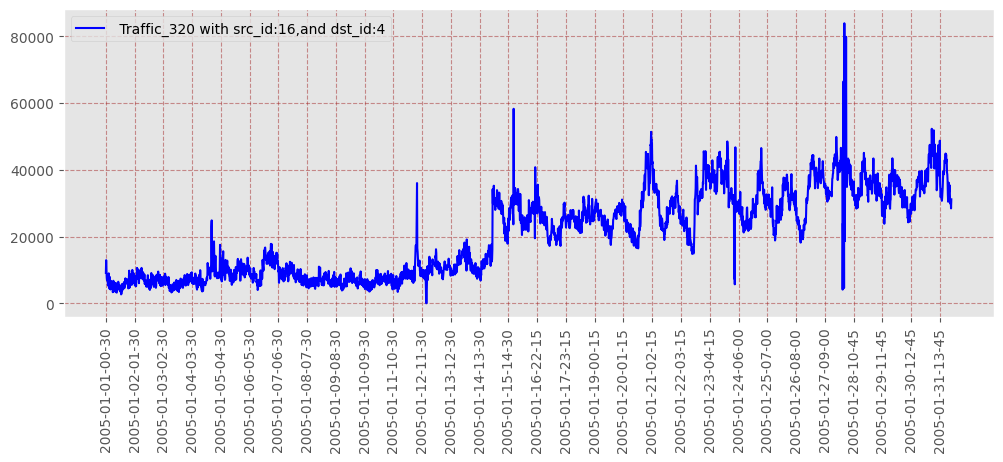

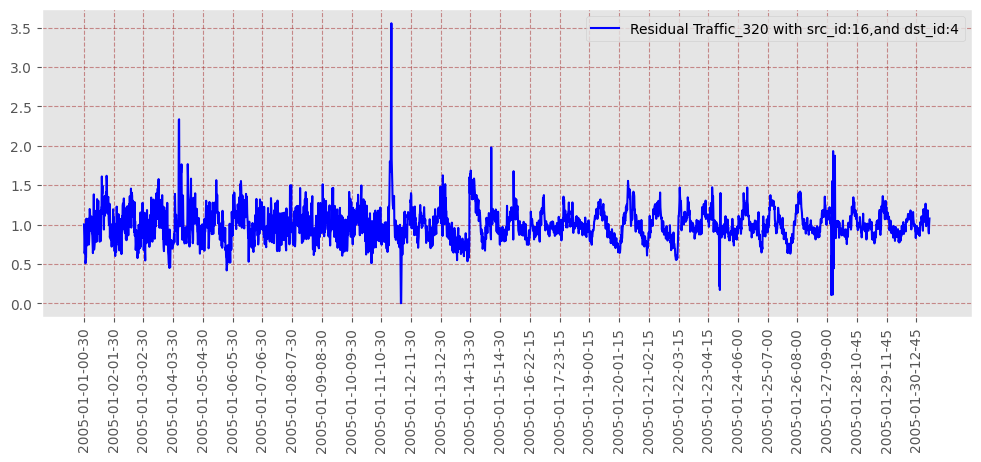

In [28]:
plot_graph(dataframe=traffic_dataframe,row=320)
plot_graph(dataframe=residual_dataframe,row=320,decompose=False,additioanl_title='Residual')

# Train_ Test Split

In [254]:
train = residual_dataframe.iloc[160,2:].copy()
train = np.reshape(train, (-1,1))
train.shape
# test = residual_dataframe.loc[320,"2005-01-25-00-15":].copy()

(2845, 1)

In [163]:
# plt.figure(figsize=(10, 6))
# plt.plot(train.index, train.values, label='Train Data')

# # Plot the test data
# plt.plot(test.index, test.values, label='Test Data', linestyle='--')
# plt.legend()
# plt.xticks([])
# plt.show()

# Model 1

In [255]:
X_train = list()
y_train = list()
window_size = 20
for i in range(window_size, len(train)):
    X_train.append(train[i-window_size:i, 0])
    y_train.append(train[i, 0])




In [256]:
# The data is converted to Numpy array
X_train, y_train = np.array(X_train), np.array(y_train)
print('X_train.shape: ',X_train.shape)
print('Y_train.shape: ',y_train.shape)



X_train.shape:  (2825, 20)
Y_train.shape:  (2825,)


In [257]:
#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)

X_train : (2825, 20, 1) y_train : (2825, 1)


In [258]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [273]:
def Rnn(X_train,y_train):

	# initializing the RNN
	rnn = Sequential()

	# adding RNN layers and dropout regularization
	rnn.add(SimpleRNN(units = 50,
							activation = "tanh",
							return_sequences = True,
							input_shape = (X_train.shape[1],1)))
	rnn.add(Dropout(0.2))

	rnn.add(SimpleRNN(units = 50,
							activation = "tanh",
							return_sequences = True))

	rnn.add(SimpleRNN(units = 50,
							activation = "tanh",
							return_sequences = True))

	rnn.add( SimpleRNN(units = 50))

	# adding the output layer
	rnn.add(Dense(units = 1))

	# compiling RNN
	rnn.compile(optimizer = 'adam',
												loss = 'mean_squared_error'
												)

	# fitting the model
	rnn.fit(X_train, y_train, epochs = 3, batch_size = 4)

	return rnn

In [260]:
Rnn = Rnn(X_train, y_train)

Epoch 1/3
707/707 [==============================] - 22s 26ms/step - loss: 0.6602
Epoch 2/3
707/707 [==============================] - 20s 28ms/step - loss: 0.5896
Epoch 3/3
707/707 [==============================] - 15s 22ms/step - loss: 0.5602


In [261]:
y_train_pred = Rnn.predict(X_train)

89/89 [==============================] - 1s 8ms/step


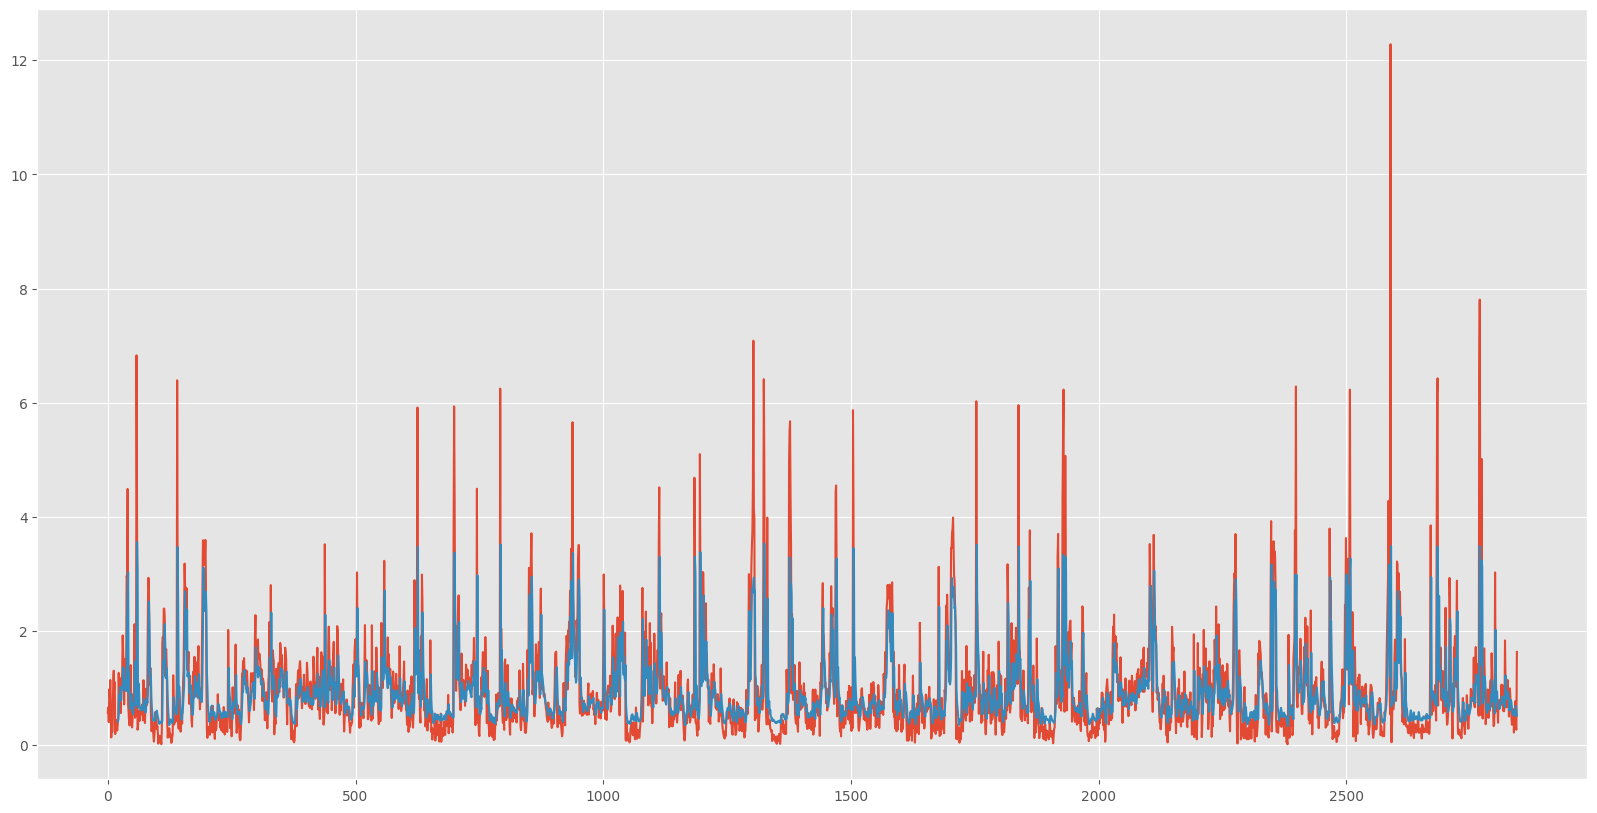

In [262]:
plt.figure(figsize=(20,10))

# Plot the first graph
plt.plot(np.arange(len(train)), train, label='y_train')

# Plot the second graph with a 20 item offset
plt.plot(20 + np.arange(len(y_train_pred)), y_train_pred, label='y_train_pred')

In [263]:
y_train_pred =  np.squeeze(y_train_pred)
y_train_pred.shape

(2825,)

In [264]:
sea = seasonal_dataframe.iloc[160,22:].values
tre = trend_dataframe.iloc[160,22:].values
result = y_train_pred * sea * tre

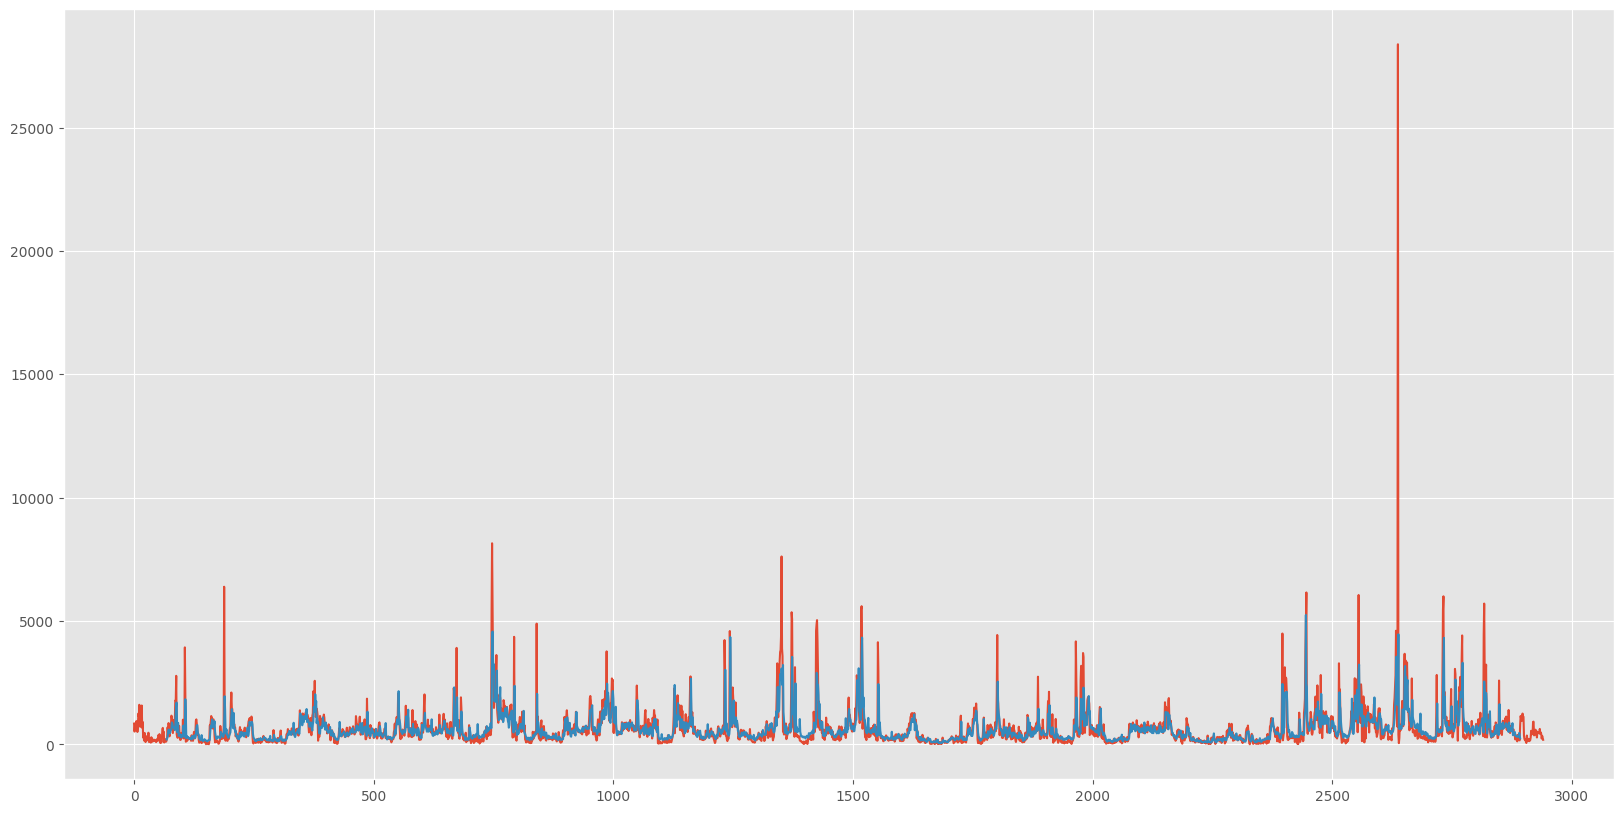

In [265]:
plt.figure(figsize=(20,10))

# Plot the first graph
plt.plot(np.arange(len(org)), org, label='y_train')

# Plot the second graph with a 20 item offset
plt.plot(20+np.arange(len(result))+48, result, label='y_train_pred')

In [267]:
def create_sequences(data, window_size, prediction_size):
    X_train = []
    y_train = []
    for i in range(len(data) - window_size - prediction_size + 1):
        X_train.append(data[i:(i + window_size)])
        y_train.append(data[(i + window_size):(i + window_size + prediction_size)])
    return np.array(X_train), np.array(y_train)



In [269]:
X_train,y_train=  create_sequences(train, 20, 10)

In [270]:
print('X_train.shape: ',X_train.shape)
print('Y_train.shape: ',y_train.shape)



X_train.shape:  (2816, 20, 1)
Y_train.shape:  (2816, 10, 1)


In [271]:
#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],y_train.shape[1],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)

X_train : (2816, 20, 1) y_train : (2816, 10, 1)


In [274]:
Rnn = Rnn(X_train, y_train)

Epoch 1/3
704/704 [==============================] - 18s 21ms/step - loss: 0.8367
Epoch 2/3
704/704 [==============================] - 16s 22ms/step - loss: 0.8084
Epoch 3/3
704/704 [==============================] - 15s 21ms/step - loss: 0.8020


In [275]:
y_train_pred = Rnn.predict(X_train)

88/88 [==============================] - 1s 8ms/step


In [276]:
X_train.shape

(2816, 20, 1)

In [277]:
y_train_pred.shape

(2816, 1)

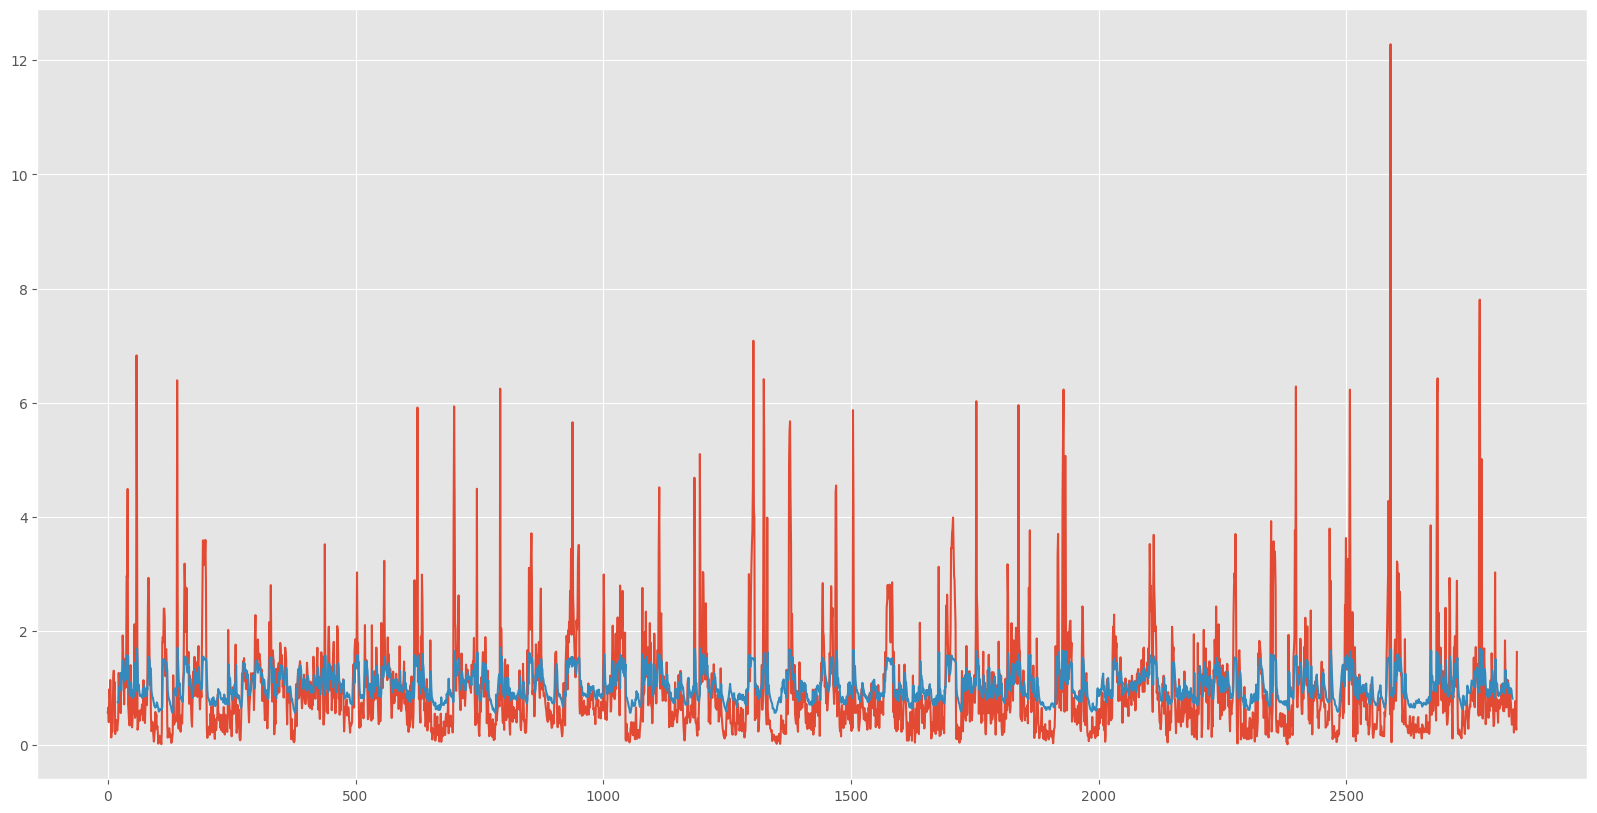

In [278]:
plt.figure(figsize=(20,10))

# Plot the first graph
plt.plot(np.arange(len(train)), train, label='y_train')

# Plot the second graph with a 20 item offset
plt.plot(20 + np.arange(len(y_train_pred)), y_train_pred, label='y_train_pred')

In [279]:
y_train_pred =  np.squeeze(y_train_pred)
y_train_pred.shape

(2816,)